# Hierarchical ARHMM Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

In [3]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 5    # number of discrete states
obs_dim = 2       # dimensionality of observation
lags = 1          # number of lags in the AR model

# Specify tags for the hierarchical AR model
tags = ["matt", "scott"]

# Make an HMM
true_harhmm = ssm.HMM(num_states, obs_dim, 
                      observations="hierarchical_ar", 
                      observation_kwargs=dict(lags=lags, tags=tags))

# Plot dynamics functions for the two groups (tags)

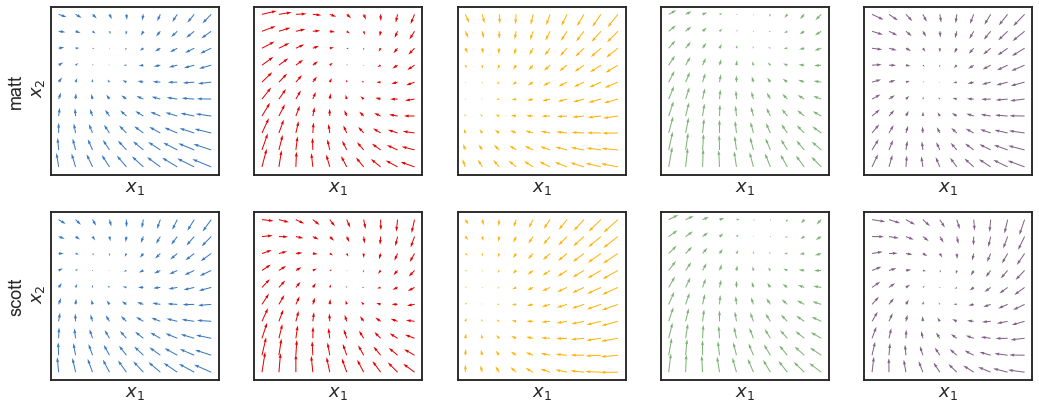

In [4]:
x = np.linspace(-8, 8, 10)
y = np.linspace(-8, 8, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

fig, axs = plt.subplots(len(tags), num_states, figsize=(3 * num_states, 6))
for i, tag in enumerate(tags):
    for k, (A, b) in enumerate(zip(
        true_harhmm.observations.per_group_ar_models[i].As, 
        true_harhmm.observations.per_group_ar_models[i].bs)):
        
        dxydt_m = xy.dot(A.T) + b - xy
        axs[i, k].quiver(xy[:, 0], xy[:, 1],
                  dxydt_m[:, 0], dxydt_m[:, 1],
                  color=colors[k % len(colors)])

        
        axs[i,k].set_xlabel('$x_1$')
        axs[i,k].set_xticks([])
#         axs[i,k].set_ylabel('$x_2$')
        if k == 0:
            axs[i,k].set_ylabel(tag + "\n $x_2$")
        axs[i,k].set_yticks([])
        axs[i,k].set_aspect("equal")
                    

plt.tight_layout()

# Sample data from the hierarchical ARHMM

In [5]:
# Sample some data from the HMM
tags = tags * 5
true_states, datas = list(zip(*[true_harhmm.sample(time_bins, tag=tag) for tag in tags]))
true_lp = true_harhmm.log_probability(datas, tags=tags)

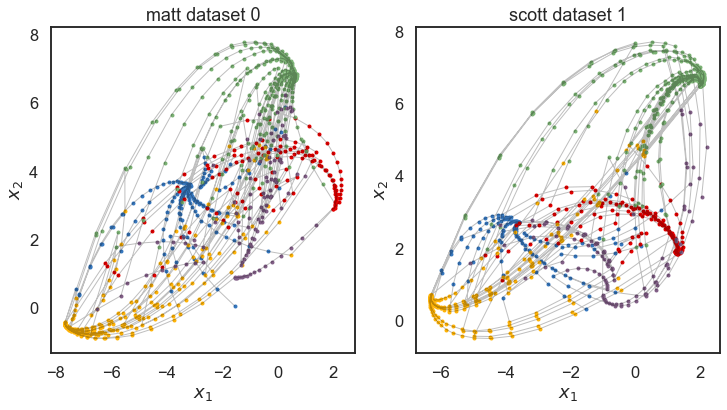

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for idx, ax in enumerate(axs):
    zs = true_states[idx]
    for k in range(num_states):
        ax.plot(datas[idx][true_states[idx]==k, 0], 
                datas[idx][true_states[idx]==k, 1], 
                'o', mfc=colors[k], mec='none', ms=4)

    ax.plot(datas[idx][:,0], datas[idx][:,1], '-k', lw=1, alpha=.25)
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")
    ax.set_title(tags[idx] + " dataset " + str(idx % 2))

Below, we visualize each component of of the observation variable as a time series. The colors correspond to the latent state. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

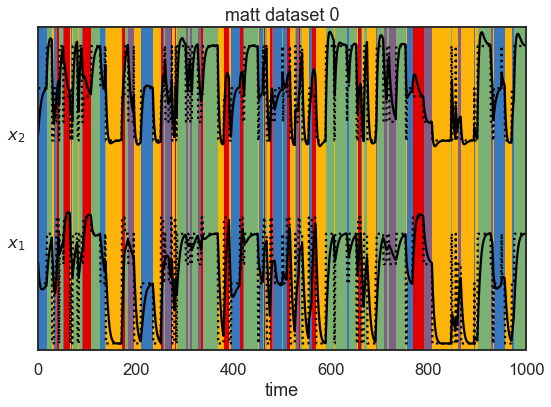

In [7]:
# Compute the stationary point for each AR model
assert lags == 1
idx = 0
As = true_harhmm.observations.get_As(tags[idx])
bs = true_harhmm.observations.get_bs(tags[idx])
mus = np.linalg.solve(np.eye(obs_dim) - As, bs)

# Plot the data and the smoothed data
lim = 1.05 * abs(datas[idx]).max()
plt.figure(figsize=(8, 6))
plt.imshow(true_states[idx][None,:],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (obs_dim)*lim))


Ey = mus[true_states[idx]]
for d in range(obs_dim):
    plt.plot(datas[idx][:,d] + lim * d, '-k')
    plt.plot(Ey[:,d] + lim * d, ':k')

plt.xlim(0, time_bins)
plt.xlabel("time")
plt.yticks(lim * np.arange(obs_dim), ["$x_{}$".format(d+1) for d in range(obs_dim)])

plt.title(tags[idx] + " dataset " + str(idx % 2))

plt.tight_layout()


# 4. Fit a regular ARHMM to all the data

In [8]:
N_iters = 100

reg_arhmm = ssm.HMM(num_states, obs_dim, 
              observations="ar",
              observation_kwargs=dict(lags=lags))
reg_arhmm_lps = reg_arhmm.fit(datas, tags=tags, 
                              method="em", 
                              num_iters=N_iters,
                              tolerance=1e-4)

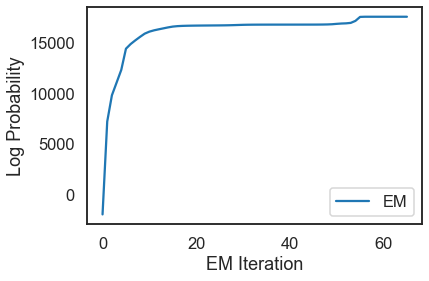

In [9]:
plt.plot(reg_arhmm_lps, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

# Fit a hierarchical ARHMM to all the data (using tag info)

In [10]:
N_iters = 100

# testing the constrained transitions class
harhmm = ssm.HMM(num_states, obs_dim, 
              observations="hierarchical_ar",
              observation_kwargs=dict(lags=lags, tags=tags))
harhmm_lps = harhmm.fit(datas, tags=tags,
                        method="em", 
                        num_iters=N_iters,
                        tolerance=1e-4)

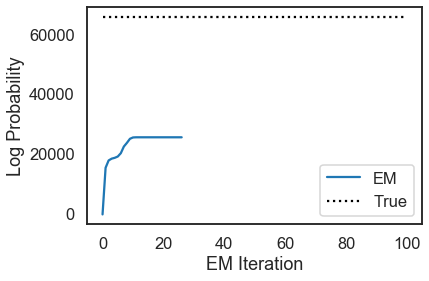

In [11]:
plt.plot(harhmm_lps, label="EM")
plt.plot([0, N_iters], true_harhmm.log_probability(datas, tags=tags) * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

# Compare true and inferred states

In [12]:
# Find a permutation of the states that best matches the true and inferred states
def align_states(inf_arhmm):
    most_likely_states = [inf_arhmm.most_likely_states(data, tag=tag) 
                          for data, tag in zip(datas, tags)]

    inf_arhmm.permute(find_permutation(np.concatenate(true_states), 
                                 np.concatenate(most_likely_states)))

    most_likely_states = [inf_arhmm.most_likely_states(data, tag=tag) 
                          for data, tag in zip(datas, tags)]

    expected_states = [inf_arhmm.expected_states(data, tag=tag)[0]
                       for data, tag in zip(datas, tags)]
    
    return most_likely_states, expected_states

reg_arhmm_states, reg_arhmm_expectations = align_states(reg_arhmm)
harhmm_states, harhmm_expectations = align_states(harhmm)

In [13]:
def confusion_matrix(true_states, inf_states):
    confusion = np.zeros((num_states, num_states))
    for i in range(num_states):
        for j in range(num_states):
            for ztrue, zinf in zip(true_states, inf_states):
                confusion[i, j] += np.sum((ztrue == i) & (zinf == j))
    return confusion

reg_arhmm_confusion = confusion_matrix(true_states, reg_arhmm_states)


harhmm_confusions = []
for tag in ["matt", "scott"]:
    harhmm_confusions.append(
        confusion_matrix(
            [z for z, t in zip(true_states, tags) if t == tag], 
            [z for z, t in zip(harhmm_states, tags) if t == tag]))


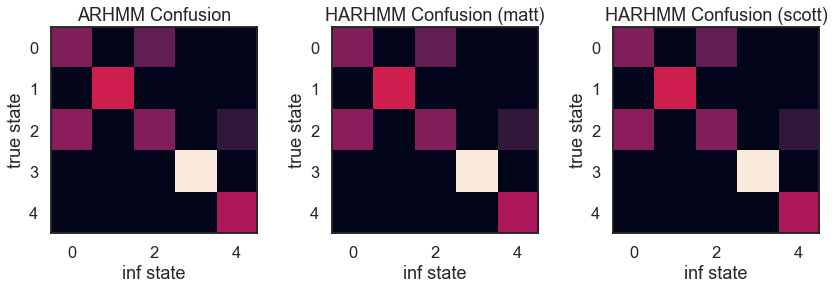

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].imshow(reg_arhmm_confusion)
axs[0].set_xlabel("inf state")
axs[0].set_ylabel("true state")
axs[0].set_title("ARHMM Confusion")

for i, (tag, conf) in enumerate(zip(["matt", "scott"], harhmm_confusions)):
    axs[i+1].imshow(reg_arhmm_confusion)
    axs[i+1].set_xlabel("inf state")
    axs[i+1].set_ylabel("true state")
    axs[i+1].set_title("HARHMM Confusion (" + tag + ")")

plt.tight_layout()

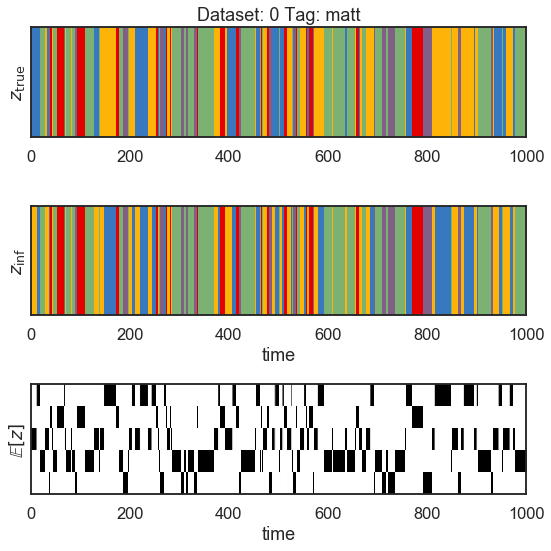

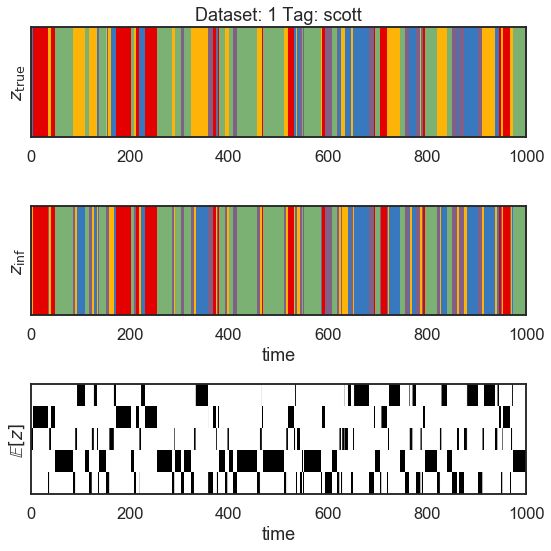

In [16]:
# Plot the true and inferred discrete states
for idx in range(2):
    plt.figure(figsize=(8, 8))
    plt.subplot(311)
    plt.imshow(true_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{true}}$")
    plt.yticks([])
    plt.title("Dataset: {} Tag: {}".format(idx, tags[idx]))

    plt.subplot(312)
    plt.imshow(reg_arhmm_states[idx][None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
    plt.xlim(0, time_bins)
    plt.ylabel("$z_{\\mathrm{inf}}$")
    plt.yticks([])
    plt.xlabel("time")

    plt.subplot(313)
    plt.imshow(reg_arhmm_expectations[idx].T, aspect="auto", cmap="Greys", vmin=0, vmax=1)
    plt.xlim(0, time_bins)
    plt.ylabel("$\mathbb{E}[z]$")
    plt.yticks([])
    plt.xlabel("time")

    plt.tight_layout()

# Plot the true and inferred dynamics

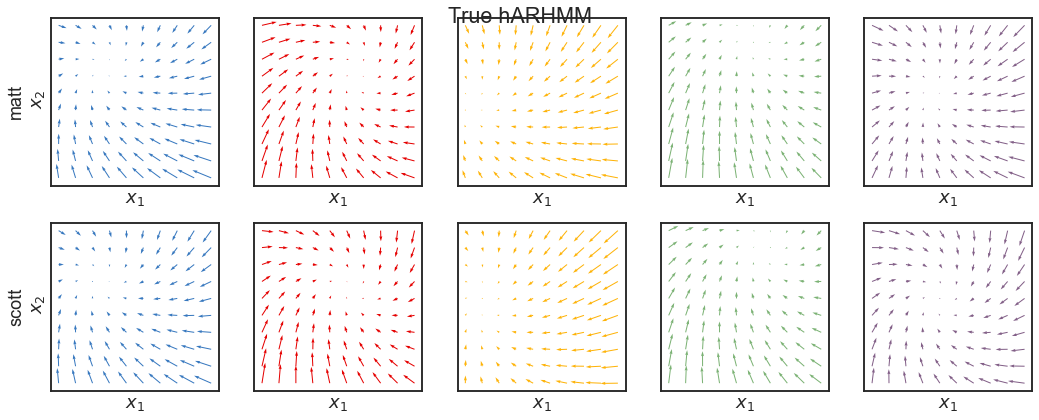

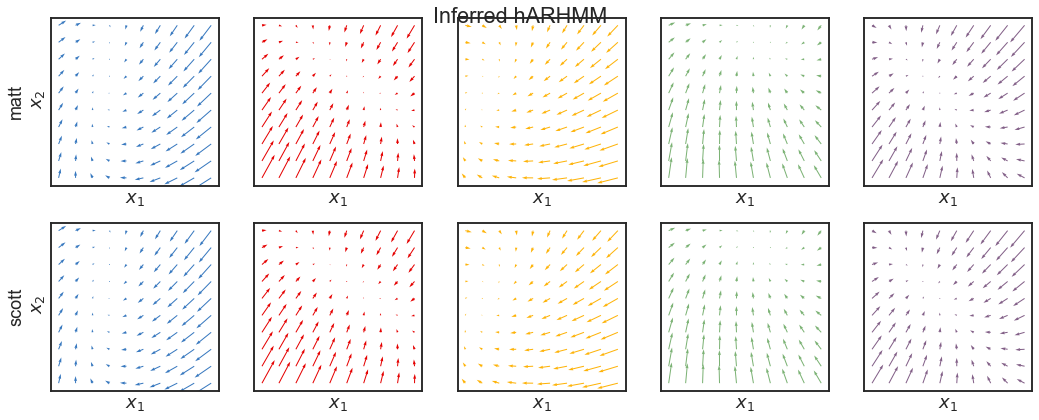

In [19]:
x = np.linspace(-8, 8, 10)
y = np.linspace(-8, 8, 10)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

def plot_all_dynamics(model, title, tags):
    fig, axs = plt.subplots(len(tags), num_states, figsize=(3 * num_states, 6))
    for i, tag in enumerate(tags):
        for k, (A, b) in enumerate(zip(
            model.observations.per_group_ar_models[i].As, 
            model.observations.per_group_ar_models[i].bs)):

            dxydt_m = xy.dot(A.T) + b - xy
            axs[i, k].quiver(xy[:, 0], xy[:, 1],
                      dxydt_m[:, 0], dxydt_m[:, 1],
                      color=colors[k % len(colors)])


            axs[i,k].set_xlabel('$x_1$')
            axs[i,k].set_xticks([])
    #         axs[i,k].set_ylabel('$x_2$')
            if k == 0:
                axs[i,k].set_ylabel(tag + "\n $x_2$")
            axs[i,k].set_yticks([])
            axs[i,k].set_aspect("equal")
    fig.suptitle(title)                
    plt.tight_layout()
    
plot_all_dynamics(true_harhmm, "True hARHMM", ["matt", "scott"])
plot_all_dynamics(harhmm, "Inferred hARHMM", ["matt", "scott"])